In [1]:
import os
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt

df_road = pd.read_csv("../database/data/road.csv")
df_rel = pd.read_csv("../database/data/rel.csv")

num_road = df_road['id'].count()
num_rel = df_rel['id'].count()

In [2]:
# 形成邻接表
graph_to = [[] for _ in range(num_road)]    # 这里是出边
graph_from = [[] for _ in range(num_road)]  # 这里是入边
for idx, rel in df_rel.iterrows():
    origin = int(rel[1])
    target = int(rel[2])
    graph_to[origin].append(target)
    graph_from[target].append(target)


C:\Users\admin\AppData\Local\Temp\ipykernel_10688\3243666799.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  origin = int(rel[1])
C:\Users\admin\AppData\Local\Temp\ipykernel_10688\3243666799.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = int(rel[2])


In [3]:
# 定义路段相似度.
def shapeSim(row1, row2):
    '''
    这个函数左右不对称，所以应该左右两边各算一次，取平均值或者最大值.
    '''
    coord1 = np.array(ast.literal_eval(row1[1]) if type(row1[1])==str else row1[1])
    coord1 = (coord1 - coord1[0,:]) * 1000
    coord2 = np.array(ast.literal_eval(row2[1]) if type(row2[1])==str else row2[1])
    coord2 = (coord2 - coord2[0,:]) * 1000
    # 总长度归一化. ——暂时先不归一化了..
    # 插值缺少的点.
    num_points1 = coord1.shape[0]
    num_points2 = coord2.shape[0]
    diff = num_points1 - num_points2
    skip_shape = False    # shape 相似度直接为0
    if diff > 0:
        if diff > num_points2 - 1:
            skip_shape = True
        else:
            coord2 = addPoints(coord2, diff)
    elif diff<0:
        diff = -diff
        if diff > num_points1 - 1:
            skip_shape = True
        else:
            coord1 = addPoints(coord1, diff)
    if not skip_shape:
        # 变成齐次坐标.
        coord1 = coord1[1:,:] - coord1[:-1,:]
        coord2 = coord2[1:,:] - coord2[:-1,:]
        # print(coord1)
        # print(coord2)
        coord1 = np.concatenate((coord1, np.ones((coord1.shape[0], 1))), axis=1)
        coord2 = np.concatenate((coord2, np.ones((coord2.shape[0], 1))), axis=1)
        delta = 0
        # 因为是行向量，所以应该是coord2 = coord1 * A
        if coord1.shape[0] > coord1.shape[1]:     # 可以求伪逆.
            coord1_pinv = np.linalg.pinv(coord1)
            #print(coord1_pinv.shape, coord2.shape, coord1.shape)
            A = np.matmul(coord1_pinv, coord2)
            #print(A)
            # test = np.matmul(coord1, A)
            # test = test[:,:-1] / (test[:,-1][:,np.newaxis] + 1e-6)
            # delta = np.sum(np.abs(coord2[:,:-1] - test))
            delta += np.abs(np.sum(A**2) - 3)
            coord2_pinv = np.linalg.pinv(coord2)
            A = np.matmul(coord2_pinv, coord1)
            delta += np.abs(np.sum(A**2) - 3)
        else:     # 不可以求伪逆，用最小二乘法.
            A = np.linalg.lstsq(coord1, coord2, rcond=None)[0]
            #print(A)
            delta += np.abs(np.sum(A**2) - coord1.shape[0])
            A = np.linalg.lstsq(coord2, coord1, rcond=None)[0]
            delta += np.abs(np.sum(A**2) - coord1.shape[0])
        # 用Sigmoid函数，加点变换.
        # 1/(1+e^{10x-5})
        #shape_sim = 1/(1+np.exp(10*delta - 5))
        delta /= 2
        shape_sim = 1/(1+np.exp(delta - 5)) if delta < 20 else 0
    else:
        shape_sim = 0

    return shape_sim

def addPoints(pointArr:np.ndarray, addnum:int):
    '''
    约束addnum < 点个数-1（线段个数），也就是最多插值一次.
    '''
    newpoints = (pointArr[1:,:] + pointArr[:-1,:]) / 2
    ret = []
    i = 0
    while i<addnum:
        ret.append(pointArr[i,:].flatten())
        ret.append(newpoints[i,:].flatten())
        i += 1
    while i< pointArr.shape[0]:
        ret.append(pointArr[i,:].flatten())
        i += 1
    return np.array(ret)


def topoSim(row1, row2, highway_coef = 0.5, topo_coef = 0.5):
    highwayTypeNum = 14
    id1 = int(row1[0])
    id2 = int(row2[0])
    highway1 = int(row1[2])
    highway2 = int(row2[2])
    highwaySim = float(highway1 == highway2)

    # 考虑的话是在太慢了，图中前后连接的话实在太慢，不要一个一个算.
    # topoSim = 0
    # for graph in [graph_from, graph_to]:
    #     total = len(graph[id1]) + len(graph[id2])
    #     if total == 0:
    #         #topoSim += 1
    #         continue
    #     highway_cnt1 = [0 for _ in range(highwayTypeNum)]
    #     highway_cnt2 = [0 for _ in range(highwayTypeNum)]
    #     for i in graph_from[id1]:
    #         from_highway = int(df_road.iloc[id1][2])
    #         highway_cnt1[from_highway] += 1
    #     for i in graph_from[id2]:
    #         from_highway = int(df_road.iloc[id2][2])
    #         highway_cnt2[from_highway] += 1
    #     cnt1 = np.array(highway_cnt1)
    #     cnt2 = np.array(highway_cnt2)
    #     s = np.sum(np.where(cnt1<cnt2, cnt1, cnt2))
    #     topoSim += s / (total)
    # topoSim /= 2
    return highwaySim

def roadSim(row1, row2):
    #shape_sim = min(shapeSim(row1, row2), shapeSim(row2, row1))
    shape_sim = shapeSim(row1, row2)
    topo_sim = topoSim(row1, row2)
    return (shape_sim + topo_sim) / 2

In [4]:
road1 = df_road.iloc[1]
road2 = df_road.iloc[8]
#ast.literal_eval(road1[1])
#topoSim(road1, road2)
#print(roadSim(road1, road2))
m = np.zeros((num_road,))
for idx, road in df_road.iterrows():
    m[idx] = roadSim(road1, road)

C:\Users\admin\AppData\Local\Temp\ipykernel_10688\998775616.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord1 = np.array(ast.literal_eval(row1[1]) if type(row1[1])==str else row1[1])
C:\Users\admin\AppData\Local\Temp\ipykernel_10688\998775616.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord2 = np.array(ast.literal_eval(row2[1]) if type(row2[1])==str else row2[1])
C:\Users\admin\AppData\Local\Temp\ipykernel_10688\998775616.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beh

In [134]:
df = pd.DataFrame(m, columns=['distance'])
df.to_csv('tmp.csv', index=True)

In [ ]:
# KMeans 算法.
# class Cluster:
#     merge_threshold = 1e-5
#     def __init__(self, cls:int) -> None:
#         self.highway_mask = np.zeros((14))
#         self.total_points = 0   # 点的总数. - 用来求“中心”
#         self.size = 0
#         self.center_line = None
#         self.center_highway = 0   # 这个用最多的那个类型..
#         self.center_pos = None
#         self.ids = []
#         self.cls = cls
    
#     def Add(self, row):
#         if self.size == 0:
#             self.center_line = ast.literal_eval(row[1])
#             self.center_highway = int(row[2])
#             self.highway_mask[self.center_highway] += 1
#             self.ids.append(int(row[0]))
#             self.total_points += len(self.center_line)
#             self.center_pos = np.mean(np.array(self.center_line), axis=0)
#         else:
#             self.ids.append(int(row[0]))
#             new_line = ast.literal_eval(row[1])
#             # 前两个点一定有，直接求平均(增量式)
#             for i in [0,1]:
#                 for j in [0,1]:
#                     self.center_highway[i][j] = (self.size*self.center_highway[i][j] \
#                           + new_line[i][j]) / (self.size+1)
#             # 后面的点，用向量求平均的方式，可以预见这个之后几乎会越来越小. 但点只增不减是不行的.
            

#         self.size += 1

# n_clusters = 3


In [5]:
# 因为求平均比较困难，所以用DBScan.
from sklearn.cluster import DBSCAN
import pickle
from tqdm import tqdm

metric = np.zeros((num_road, num_road))
for i in tqdm(range(num_road)):
    for j in range(num_road):
        if i<j:
            metric[i,j] = metric[j,i]
        elif i>j:
            metric[i,j] = roadSim(df_road.iloc[i], df_road.iloc[j])

  0%|          | 0/38027 [00:00<?, ?it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_10688\998775616.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord1 = np.array(ast.literal_eval(row1[1]) if type(row1[1])==str else row1[1])
C:\Users\admin\AppData\Local\Temp\ipykernel_10688\998775616.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coord2 = np.array(ast.literal_eval(row2[1]) if type(row2[1])==str else row2[1])
C:\Users\admin\AppData\Local\Temp\ipykernel_10688\998775616.py:84: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated

KeyboardInterrupt: 

## 用已经算好的sim矩阵进行聚类.

In [3]:
import pickle
from sklearn.cluster import DBSCAN
from tqdm import tqdm

sim = np.zeros((num_road, num_road), dtype=np.float32)
for fname in os.listdir("./"):
    if fname.endswith(".pkl"):
        with open(fname, "rb") as f:
            m = pickle.load(f)
            split = fname[:-4].split('_')
            start = int(split[1])
            end = int(split[2])
            sim[start:end, :] = np.float32(m)

print("sim matrix loaded")

dis = np.float32(1.0) - sim
for i in tqdm(range(num_road)):
    for j in range(i):
        dis[i,j] = dis[j,i]
#dis = (dis + dis.T) / 2
print("dis matrix prepared. running dbscan..")

sim matrix loaded


100%|██████████| 38027/38027 [01:44<00:00, 363.52it/s] 


dis matrix prepared. running dbscan..


In [9]:
db = DBSCAN(0.4, min_samples=500, metric="precomputed")
label = db.fit_predict(dis)

In [8]:
highway_mask = np.zeros((14,))
for idx, road in df_road.iterrows():
    highway_mask[int(road[2])] += 1
print(highway_mask)

C:\Users\admin\AppData\Local\Temp\ipykernel_26508\3171421342.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  highway_mask[int(road[2])] += 1


[ 2669.   550.   125.   231.  1643.   310. 15672.    68.  2583.   547.
 10062.  1222.  1201.  1144.]


-1 7
[0 0 0 ... 4 4 4]
[ 4709.  1272.  1069.  9473.  2035. 15385.   888.   754.  2442.]


(array([ 4709.,  1272.,  1069.,  9473.,     0.,  2035., 15385.,   888.,
          754.,  2442.]),
 array([-1. , -0.2,  0.6,  1.4,  2.2,  3. ,  3.8,  4.6,  5.4,  6.2,  7. ]),
 <BarContainer object of 10 artists>)

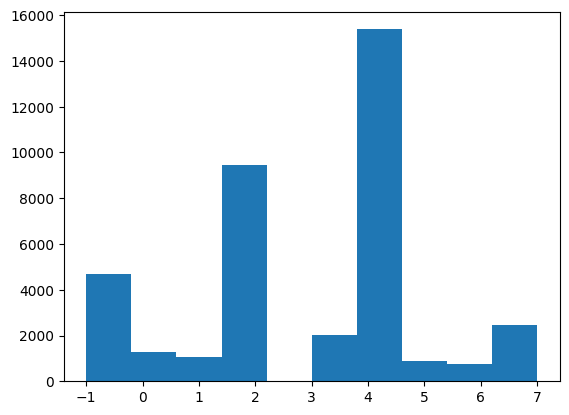

In [14]:
import matplotlib.pyplot as plt
print(label.min(), label.max())
print(label)

cnt = np.zeros((label.max() - label.min() + 1,))
for l in label:
    cnt[l+1] += 1
print(cnt)

plt.hist(label)

In [12]:
# 保存一个label.
with open("pkl_label_eps0.4_mst500.cluster", "wb") as f:
    pickle.dump(label, f)